In [48]:
#hide
from utils import *
from fastai.vision.widgets import *

In [49]:
import os

In [50]:
key = '60cba06b608f4105b5db1483a4164582'

In [52]:
results = search_images_bing(key, 'hedgehog')
ims = results.attrgot('content_url')
len(ims)


150

In [53]:
ims[3]

'https://media.npr.org/assets/img/2016/01/25/7856738032_74e9cc0807_o_wide-d9e64ff1bfa51089561a9ff1dc276dc10ad86796.jpg?s=1400'

In [54]:
#hide
# ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [55]:
dest = 'images/hedgie.jpg'
download_url(ims[4], dest)

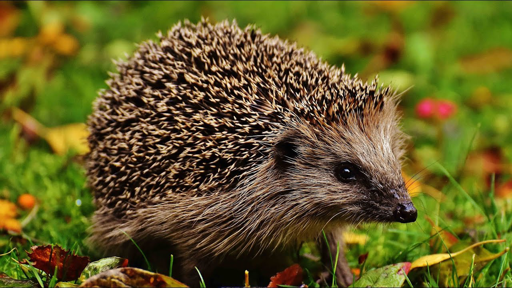

In [56]:
im = Image.open(dest)
im.to_thumb(512,512)

In [57]:
hog_types = 'hedge','hog','hedgehog'
path = Path('hedgehogs')

In [58]:
if not path.exists():
    path.mkdir()
    for o in hog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [59]:
fns = get_image_files(path)
len(fns)

443

In [60]:
failed = verify_images(fns)
len(failed)

0

In [61]:
failed.map(Path.unlink);

In [62]:
hogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [63]:
dls = hogs.dataloaders(path)

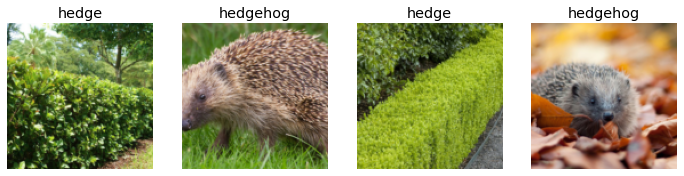

In [64]:
dls.valid.show_batch(max_n=4, nrows=1)

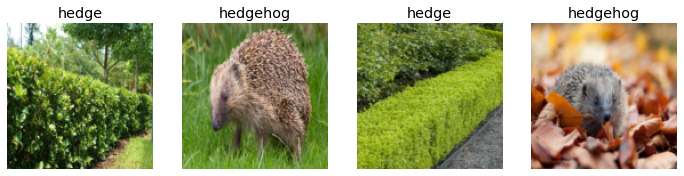

In [65]:
hogs = hogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = hogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

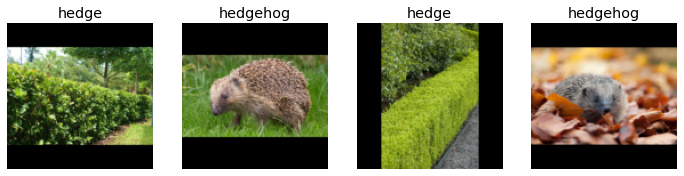

In [66]:
hogs = hogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = hogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

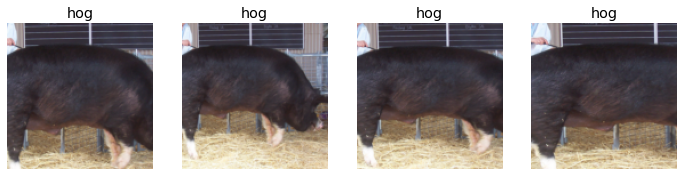

In [67]:
hogs = hogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = hogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

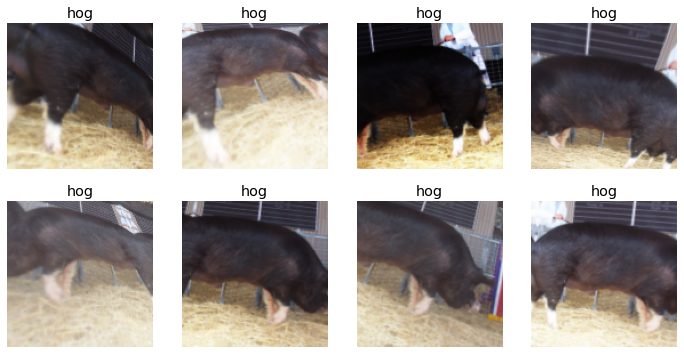

In [68]:
hogs = hogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = hogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [69]:
hogs = hogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hogs.dataloaders(path)

In [70]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.522003,0.323906,0.090909,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.213862,0.150877,0.045455,00:03
1,0.166122,0.049739,0.034091,00:03
2,0.177957,0.016175,0.011364,00:03
3,0.158640,0.017613,0.000000,00:03


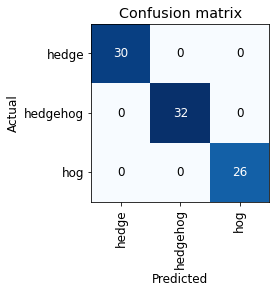

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

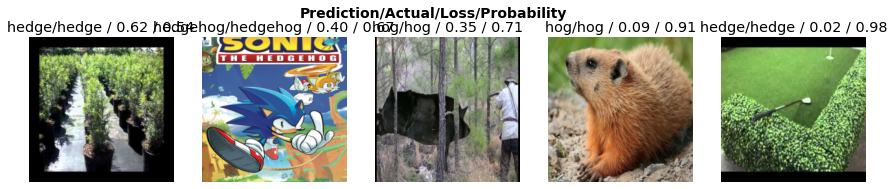

In [72]:
interp.plot_top_losses(5, nrows=1)

In [73]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [74]:
def get_xiaomi(N=1):
    picdir = "/home/brandon/Pictures/Xiaomi/select"
    xiaomipics = os.listdir(picdir)
    return os.path.join(picdir, xiaomipics[N])

('hedgehog', tensor(1), tensor([2.3587e-06, 1.0000e+00, 3.5530e-08]))


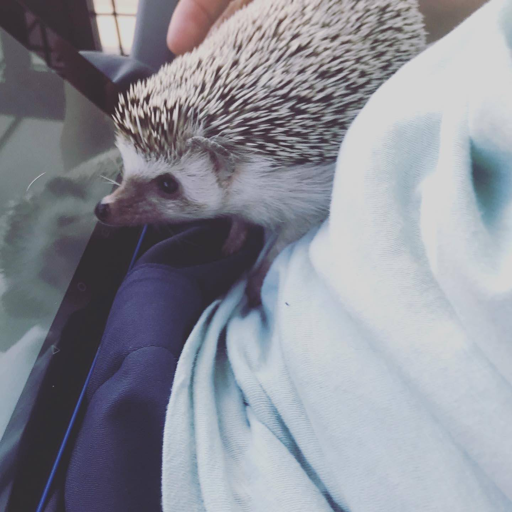

In [75]:
N = 40
xiaomi_pic = get_xiaomi(N)
im = Image.open(xiaomi_pic)
print(learn.predict(xiaomi_pic))
im.to_thumb(512,512)

('hedge', tensor(0), tensor([9.9811e-01, 1.7203e-03, 1.7025e-04]))


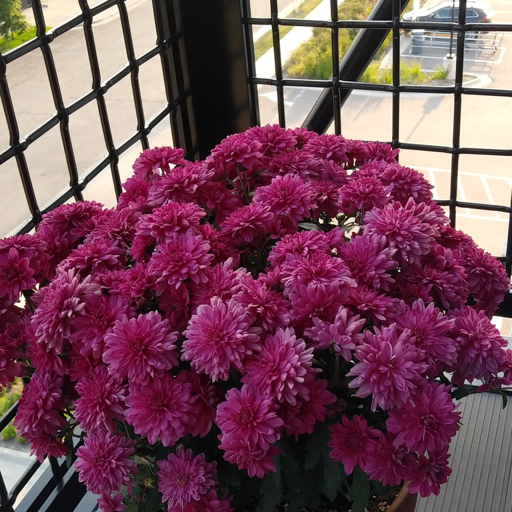

In [76]:
flowers = "/home/brandon/Desktop/flowers.jpg"
im = Image.open(flowers)
print(learn.predict(flowers))
im.to_thumb(512,512)

('hog', tensor(2), tensor([0.0156, 0.0246, 0.9598]))


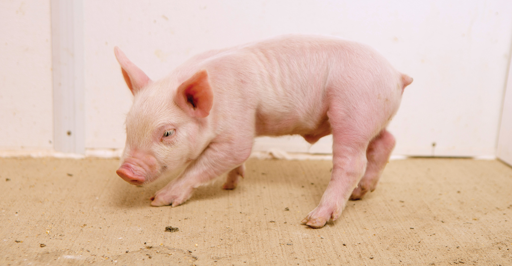

In [77]:
piglet = "/home/brandon/Desktop/piglet.jpg"
im = Image.open(piglet)
print(learn.predict(piglet))
im.to_thumb(512,512)

In [78]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)